In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import starbars as sb

In [ ]:
# Change this to your batch run directory: batch_run_YYYYMMDD_HHMMSS
batch_run = "batch_run_YYYYMMDD_HHMMSS"
dir = f"./batch_results/{batch_run}/"

In [3]:
batch_csv = dir + "summary/batch_results.csv"
batch_df = pd.read_csv(batch_csv)
batch_df.head(5)

,run_id,trained_win_rate,trained_avg_reward,basic_win_rate,basic_avg_reward,duration,timestamp
0,1,0.3989,-0.1222,0.3884,-0.1512,971.733506,2025-08-11T14:33:06.485111
1,2,0.3994,-0.1248,0.3938,-0.1435,917.433419,2025-08-11T14:48:24.565790
2,3,0.4056,-0.1163,0.3985,-0.1334,926.388572,2025-08-11T15:03:51.920806
3,4,0.3990,-0.1253,0.3812,-0.1657,1021.026139,2025-08-11T15:20:54.035686
4,5,0.3944,-0.1325,0.3957,-0.1362,1015.534451,2025-08-11T15:37:50.074836


### Shapiro-Wilk Normality Test
Monte Carlo simulation is a stochastic process. This means that the distributions of `trained_win_rate`, `trained_avg_reward`, `basic_win_rate`, and `basic_avg_reward` should be normal.

In [4]:
p_trained_win_rate = stats.shapiro(batch_df["trained_win_rate"]).pvalue
p_basic_win_rate = stats.shapiro(batch_df["basic_win_rate"]).pvalue
p_trained_avg_reward = stats.shapiro(batch_df["trained_avg_reward"]).pvalue
p_basic_avg_reward = stats.shapiro(batch_df["basic_avg_reward"]).pvalue

print(f"trained_win_rate is {'normal' if p_trained_win_rate > 0.05 else 'not normal'} (p={p_trained_win_rate:.4f})")
print(f"basic_win_rate is {'normal' if p_basic_win_rate > 0.05 else 'not normal'} (p={p_basic_win_rate:.4f})")
print(f"trained_avg_reward is {'normal' if p_trained_avg_reward > 0.05 else 'not normal'} (p={p_trained_avg_reward:.4f})")
print(f"basic_avg_reward is {'normal' if p_basic_avg_reward > 0.05 else 'not normal'} (p={p_basic_avg_reward:.4f})")

trained_win_rate is normal (p=0.3110)
basic_win_rate is normal (p=0.6812)
trained_avg_reward is normal (p=0.4731)
basic_avg_reward is normal (p=0.5928)


### Paired t-Test
Because we have validated that the random variables are normally distributed, we will compare the win rates and average rewards between the trained model and basic strategy using the paired t-test. Otherwise, we would use a non-parametric test like the Wilcoxon signed-rank test.

In [5]:
p_wr = stats.ttest_rel(batch_df["trained_win_rate"], batch_df["basic_win_rate"]).pvalue
p_ar = stats.ttest_rel(batch_df["trained_avg_reward"], batch_df["basic_avg_reward"]).pvalue

print(f"The difference in win rates is {'significant' if p_wr < 0.05 else 'not significant'} (p={p_wr:.5f})")
print(f"The difference in average rewards is {'significant' if p_ar < 0.05 else 'not significant'} (p={p_ar:.5f})")

The difference in win rates is significant (p=0.00001)
The difference in average rewards is significant (p=0.00000)


### Box-and-Whiskers Plot
Now we visualize how their distributions compare to each other.

2.0 0.03
2.0 0.03


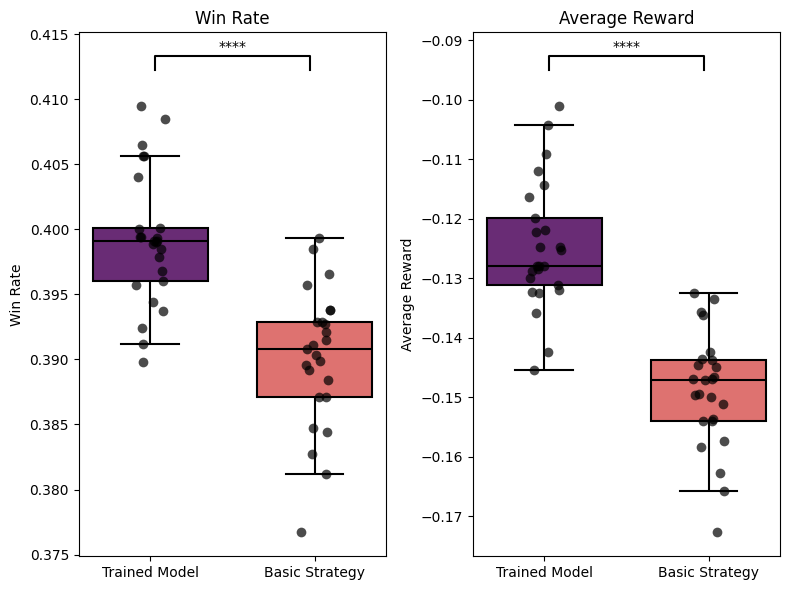

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=False)

# --- Win Rate plot ---
data_wr = batch_df.rename(
    columns={"trained_win_rate": "Trained Model", "basic_win_rate": "Basic Strategy"}
).melt(
    value_vars=["Trained Model", "Basic Strategy"],
    var_name="Model", value_name="Win Rate"
)

sns.boxplot(
    x="Model", y="Win Rate", data=data_wr,
    linewidth=1.5, linecolor="black", width=0.7,
    palette="magma", hue="Model", showfliers=False,
    ax=axes[0]
)
sns.stripplot(
    x="Model", y="Win Rate", data=data_wr,
    color="black", size=7, jitter=True, alpha=0.7, ax=axes[0]
)
axes[0].set_xlabel("")
axes[0].set_title("Win Rate")
sb.draw_annotation([("Trained Model", "Basic Strategy", p_wr)], ax=axes[0])

# --- Average Reward plot ---
data_ar = batch_df.rename(
    columns={"trained_avg_reward": "Trained Model", "basic_avg_reward": "Basic Strategy"}
).melt(
    value_vars=["Trained Model", "Basic Strategy"],
    var_name="Model", value_name="Average Reward"
)

sns.boxplot(
    x="Model", y="Average Reward", data=data_ar,
    linewidth=1.5, linecolor="black", width=0.7,
    palette="magma", hue="Model", showfliers=False,
    ax=axes[1],
)
sns.stripplot(
    x="Model", y="Average Reward", data=data_ar,
    color="black", size=7, jitter=True, alpha=0.7, ax=axes[1]
)
axes[1].set_xlabel("")
axes[1].set_title("Average Reward")
sb.draw_annotation([("Trained Model", "Basic Strategy", p_ar)], ax=axes[1])

plt.tight_layout()
plt.show()


Our trained model performs more optimally in maximizing the player's chances of winning each hand compared to relying on basic strategy.

### Finding Optimal Actions for Each Combinations (Trained Model)
We're going to dive into the individual tabular datasets produced in each of the 25 runs to understand the optimal actions the trained model takes at every possible combination.

In [7]:
states_df = pd.read_csv("./csv/blackjack_states.csv")
trained_merged_df = states_df.copy()
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double
0,4,2,False,True,True
1,4,3,False,True,True
2,4,4,False,True,True
3,4,5,False,True,True
4,4,6,False,True,True


In [8]:
for i in range(1, 26):
    file_num = f"{i:03d}"  # 001, 002, ..., 025
    run_df = pd.read_csv(f"{dir}csv_files/run_{file_num}_trained_strategy.csv")
    cols_to_add = ["best_action", "ev"]
    run_df_subset = run_df[['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'] + cols_to_add].copy()
    run_df_subset.rename(columns={col: f"{col}_{file_num}" for col in cols_to_add}, inplace=True)

    trained_merged_df = pd.merge(
        trained_merged_df,
        run_df_subset,
        on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
        how='outer'
    )

In [9]:
trained_merged_df["run_nan_count"] = trained_merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
0,4,2,False,False,True,NaN,NaN,Stand,2.0000,Hit,...,0.0000,NaN,NaN,Double,-0.5724,Hit,-0.4592,NaN,NaN,4
1,4,2,False,True,True,Double,-0.2022,Hit,-0.1419,Stand,...,-0.2694,Double,-0.2373,Stand,-0.2368,Split,-0.3456,Stand,-0.2586,0
2,4,3,False,False,True,Stand,-0.2107,Stand,0.1818,Stand,...,0.0000,Stand,-0.1764,Double,1.0300,Double,-0.4029,Stand,0.0000,3
3,4,3,False,True,True,Split,-0.0721,Hit,-0.0953,Double,...,-0.2192,Split,-0.1328,Double,-0.2160,Double,-0.1687,Double,-0.2176,0
4,4,4,False,False,True,Hit,1.0100,NaN,NaN,Stand,...,0.0000,Stand,0.2300,Double,-0.3831,Stand,0.0050,Hit,0.0000,1


In [10]:
# Check for row duplicates
if trained_merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
trained_merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2,3,4,5,6,7,8,9,10
run_nan_count,10,9,8,7,6,5,4,3,2,1,0
count,1,1,3,1,2,7,4,3,3,11,564


In [11]:
trained_best_action_cols = [col for col in trained_merged_df.columns if col.startswith("best_action_")]
trained_ev_cols = [col for col in trained_merged_df.columns if col.startswith("ev_")]

trained_best_action_cols.sort()
trained_ev_cols.sort()

def get_best_action_and_ev(row, ba_cols, ev_cols, track_source=False):
    actions = ["Hit", "Stand", "Split", "Double"]
    action_mean_evs = {}
    action_sources = {}

    for action in actions:
        evs_for_action = []
        sources_for_action = []

        for ba_col, ev_col in zip(ba_cols, ev_cols):
            if row[ba_col] == action and pd.notna(row[ev_col]):
                evs_for_action.append(row[ev_col])
                sources_for_action.append(ba_col.replace("best_action_", ""))

        if evs_for_action:
            action_mean_evs[action] = np.mean(evs_for_action)
            action_sources[action] = sources_for_action

    if not action_mean_evs:
        return (np.nan, np.nan, np.nan) if track_source else (np.nan, np.nan)

    best_action = max(action_mean_evs, key=action_mean_evs.get)
    best_ev = action_mean_evs[best_action]

    if track_source:
        best_sources = ", ".join(action_sources[best_action])
        return best_action, best_ev, best_sources
    else:
        return best_action, best_ev

In [12]:
trained_merged_df[["best_action", "ev"]] = trained_merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, trained_best_action_cols, trained_ev_cols)), axis=1
)

trained_merged_df = trained_merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev"]]
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev
0,4,2,False,False,True,Stand,1.066529
1,4,2,False,True,True,Split,-0.150133
2,4,3,False,False,True,Double,0.509680
3,4,3,False,True,True,Split,-0.142086
4,4,4,False,False,True,Hit,0.223392


### Finding Optimal Actions for Each Combinations (Basic Strategy Model)
We'll now do the same for the basic strategy model.

In [13]:
bs_merged_df = states_df.copy()

for i in range(1, 26):
    file_num = f"{i:03d}"  # 001, 002, ..., 025
    run_df = pd.read_csv(f"{dir}csv_files/run_{file_num}_basic_strategy.csv")
    cols_to_add = ["best_action", "ev"]
    run_df_subset = run_df[['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'] + cols_to_add].copy()
    run_df_subset.rename(columns={col: f"{col}_{file_num}" for col in cols_to_add}, inplace=True)

    bs_merged_df = pd.merge(
        bs_merged_df,
        run_df_subset,
        on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
        how='outer'
    )

bs_merged_df["run_nan_count"] = bs_merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
bs_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
0,4,2,False,True,True,Hit,-0.1610,Hit,-0.1779,Hit,...,-0.1799,Hit,-0.1869,Hit,-0.2261,Hit,-0.0429,Hit,-0.1867,0
1,4,3,False,True,True,Hit,-0.1301,Hit,-0.1510,Hit,...,-0.1585,Hit,-0.1758,Hit,-0.1075,Hit,-0.1848,Hit,-0.1668,0
2,4,4,False,False,True,Hit,-0.4171,Hit,-0.0281,Hit,...,-0.1735,Hit,-0.0480,Hit,-0.1307,Hit,0.3342,Hit,0.0486,0
3,4,4,False,True,True,Split,-0.0317,Split,0.0371,Split,...,0.0039,Split,-0.1349,Split,-0.1792,Split,0.1170,Split,-0.0124,0
4,4,5,False,False,True,Hit,-0.1867,Hit,0.2014,Hit,...,-0.2000,Hit,0.2636,Hit,-0.3861,Hit,0.1184,Hit,0.2570,0


In [14]:
# Check for row duplicates
if bs_merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
bs_merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2,3
run_nan_count,25,2,1,0
count,16,1,2,575


In [15]:
print(f"Unique player_sum values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['player_sum'].unique()}")
print(f"Unique dealer_visible values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['dealer_visible'].unique()}")
print(f"Unique usable_ace values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['usable_ace'].unique()}")
print(f"Unique can_split values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['can_split'].unique()}")
print(f"Unique can_double values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['can_double'].unique()}")

Unique player_sum values: [12 20]
Unique dealer_visible values: [ 2  7  8  9 10 11  3  4  5  6]
Unique usable_ace values: [ True False]
Unique can_split values: [False]
Unique can_double values: [ True]


In [16]:
bs_merged_df[bs_merged_df["run_nan_count"] == 25].sample(n=5, random_state=42)

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
178,12,2,True,False,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
208,12,7,True,False,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
232,12,11,True,False,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
585,20,10,False,False,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
580,20,9,False,False,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25


In [17]:
bs_best_action_cols = [col for col in bs_merged_df.columns if col.startswith("best_action_")]
bs_ev_cols = [col for col in bs_merged_df.columns if col.startswith("ev_")]

bs_best_action_cols.sort()
bs_ev_cols.sort()

bs_merged_df[["best_action", "ev"]] = bs_merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, bs_best_action_cols, bs_ev_cols)), axis=1
)

bs_merged_df = bs_merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev"]]
bs_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev
0,4,2,False,True,True,Hit,-0.186080
1,4,3,False,True,True,Hit,-0.155540
2,4,4,False,False,True,Hit,-0.065180
3,4,4,False,True,True,Split,-0.052484
4,4,5,False,False,True,Hit,-0.047828


### Merge Results from Both Models

In [18]:
merged_df = pd.merge(
    trained_merged_df,
    bs_merged_df,
    on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
    how='outer',
    suffixes=('_trained', '_basic')
)

merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_trained,ev_trained,best_action_basic,ev_basic
0,4,2,False,False,True,Stand,1.066529,NaN,NaN
1,4,2,False,True,True,Split,-0.150133,Hit,-0.18608
2,4,3,False,False,True,Double,0.509680,NaN,NaN
3,4,3,False,True,True,Split,-0.142086,Hit,-0.15554
4,4,4,False,False,True,Hit,0.223392,Hit,-0.06518


In [19]:
# Check for row duplicates
if merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
merged_df["run_nan_count"] = merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1
run_nan_count,1,0
count,22,578


In [20]:
best_action_cols = [col for col in merged_df.columns if col.startswith("best_action_")]
ev_cols = [col for col in merged_df.columns if col.startswith("ev_")]

best_action_cols.sort()
ev_cols.sort()

merged_df[["best_action", "ev", "source"]] = merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, best_action_cols, ev_cols, track_source=True)), axis=1
)

merged_df = merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev","source"]]
merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev,source
0,4,2,False,False,True,Stand,1.066529,trained
1,4,2,False,True,True,Split,-0.150133,trained
2,4,3,False,False,True,Double,0.509680,trained
3,4,3,False,True,True,Split,-0.142086,trained
4,4,4,False,False,True,Hit,0.079106,"basic, trained"


In [21]:
print(f"There are {merged_df.isna().any(axis=1).sum()} rows with missing action data before dropping.")

merged_cleaned_df = merged_df.dropna()
print(f"There are {merged_cleaned_df.isna().any(axis=1).sum()} rows with missing action data after dropping.")

There are 0 rows with missing action data before dropping.
There are 0 rows with missing action data after dropping.


In [22]:
uniq_source_counts = merged_cleaned_df["source"].value_counts()

print(f"SOURCE\n\
- Both agree:     {uniq_source_counts.iloc[0]} state-action combinations\n\
- Trained Agent:  {uniq_source_counts.iloc[1]} state-action combinations\n\
- Basic Strategy: {uniq_source_counts.iloc[2]} state-action combinations")

SOURCE
- Both agree:     421 state-action combinations
- Trained Agent:  165 state-action combinations
- Basic Strategy: 14 state-action combinations


### Final Combined Model Analysis

In [23]:
from typing import List

def state_representation(df: pd.DataFrame, player_values: List[int], dealer_visible: int, have_split: bool):
    player_sum = np.sum(player_values)
    usable_ace = False
    can_double = False
    can_split = False

    if 1 or 11 in player_values:
        usable_ace = True
        player_sum += 10 if player_sum + 10 <= 21 else 0
    if len(player_values) == 2:
        can_double = True
        if not have_split:
            if player_values[0] == player_values[1]:
                can_split = True
            elif (player_values[0] == 1 or player_values[0] == 11) and (player_values[1] == 1 or player_values[1] == 11):
                can_split = True

    matched_row = df[
        (df["player_sum"] == player_sum) &
        (df["dealer_visible"] == dealer_visible) &
        (df["usable_ace"] == usable_ace) &
        (df["can_split"] == can_split) &
        (df["can_double"] == can_double)
    ]
    print(matched_row)

    if not matched_row.empty:
        return matched_row[["best_action", "ev", "source"]].values[0]  # Return action and EV as array
    else:
        return ("NO_DATA", "-999", "NO_DATA")

In [24]:
merged_cleaned_df.to_csv("merged_results.csv", index=False)

In [25]:
merged_cleaned_df.describe()

,player_sum,dealer_visible,ev
count,600.000000,600.000000,600.000000
mean,13.450000,6.500000,-0.042446
std,4.521974,2.874678,0.371710
min,4.000000,2.000000,-0.777800
25%,10.000000,4.000000,-0.291958
50%,14.000000,6.500000,-0.076669
75%,17.000000,9.000000,0.154007
max,20.000000,11.000000,1.500000
